## Precinct Unique Addresses

This notebook generates a map of all unique addresses per property parcel, along with some summary statistics of properties in the precinct.

This notebook builds on the `precinct-visualization.ipnyb` notebook, and requires the `data/durham_addresses.csv.gz` file to be generated (see README.md for more information).

In [1]:
from arcgis import downloader, utils
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import os
import pandas as pd


matplotlib.style.use('ggplot')
%matplotlib inline

PRECINCT = '21'
%env PRECINCT=$PRECINCT

env: PRECINCT=21


In [2]:
!mkdir -p data

In [3]:
!test -f data/Precincts.shp || (cd data && wget https://s3.amazonaws.com/dl.ncsbe.gov/PrecinctMaps/SBE_PRECINCTS_20161004.zip && unzip SBE_PRECINCTS_20161004.zip )

In [4]:
!test -f data/precinct-$PRECINCT.shp || (cd data && ogr2ogr -sql "select * from Precincts where COUNTY_NAM='DURHAM' and PREC_ID='$PRECINCT'" -t_srs EPSG:4326 precinct-$PRECINCT.shp Precincts.shp)

In [5]:
precinct = gpd.GeoDataFrame.from_file("data/precinct-{}.shp".format(PRECINCT))
bounds = precinct.bounds

all_lots_url_template = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/89/query?f=json&geometry={},{},{},{}&returnGeometry=true&outFields=*&outSR=4326&inSR=4326"
lots = downloader.get_shp(all_lots_url_template, 'data/all_lots-{}'.format(PRECINCT), bounds)

highways_url_template = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/54/query?f=json&geometry={},{},{},{}&returnGeometry=true&outFields=*&outSR=4326&inSR=4326"
highways = downloader.get_shp(highways_url_template, 'data/highways-{}'.format(PRECINCT), bounds)

streets_url_template = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/56/query?f=json&geometry={},{},{},{}&returnGeometry=true&outFields=*&outSR=4326&inSR=4326"
streets = downloader.get_shp(streets_url_template, 'data/streets-{}'.format(PRECINCT), bounds)

PLOTSIZE = (int(10 * (bounds['maxx'].min() - bounds['minx'].min()) / (bounds['maxy'].min() - bounds['miny'].min())), 10)

In [6]:
print('Properties from arcgis boundary: {}'.format(len(lots)))

precinct = precinct.to_crs({'init': 'epsg:4326'})

lots_in_precinct = gpd.sjoin(lots, precinct, op='within')

print('Properties in precinct {}: {}'.format(PRECINCT, len(lots_in_precinct)))

lots_in_precinct.to_file('data/precinct-{}-lots.shp'.format(PRECINCT))

Properties from arcgis boundary: 1474
Properties in precinct 21: 1190


In [7]:
!rm -f data/precinct-$PRECINCT-lots.geojson && ogr2ogr -f geojson data/precinct-$PRECINCT-lots.geojson data/precinct-$PRECINCT-lots.shp

In [8]:
all_lots_pd = gpd.read_file('data/precinct-{}-lots.shp'.format(PRECINCT))
all_lots_pd.PARCEL_ID = all_lots_pd.PARCEL_ID.fillna(0).astype(int)
precinct_boundary_pd = gpd.read_file('data/precinct-{}.shp'.format(PRECINCT))
all_addresses_and_apartments = pd.read_csv('data/durham_addresses.csv.gz')

/Users/danesummers/.virtual_env/nc_election/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
# drop all duplicates - we're counting number of addresses.
# all_addresses_and_apartments = all_addresses_and_apartments.drop_duplicates('address')

In [10]:
apartments_pd = all_lots_pd.merge(all_addresses_and_apartments, on='PARCEL_ID')
# filter out properties that are definitely NOT residential:
apartments_pd = apartments_pd[~apartments_pd.LANDUSE_DE.str.startswith('REC')]
# apartments_pd = apartments_pd[~apartments_pd.LANDUSE_DE.str.startswith('VAC')]
apartments_pd = apartments_pd[~apartments_pd.LANDUSE_DE.str.startswith('PRESENT')]
# apartments_pd = apartments_pd[~apartments_pd.LANDUSE_DE.str.startswith('COM')]
apartments_pd = apartments_pd[~apartments_pd.LANDUSE_DE.str.startswith('WILD')]
apartments_pd = apartments_pd[~apartments_pd.LANDUSE_DE.str.startswith('CMNTY SVC')]
apartments_pd = apartments_pd[~apartments_pd.LANDUSE_DE.str.startswith('PUBL SVC')]
apartments_pd = apartments_pd[~apartments_pd.LANDUSE_DE.str.startswith('VACANT')]
# apartments_pd = apartments_pd[~apartments_pd.LANDUSE_DE.str.startswith('VAC RES')]
apartments_pd = apartments_pd[~apartments_pd.LANDUSE_DE.str.startswith('REC/ SOCIAL ORGANIZATIONS')]

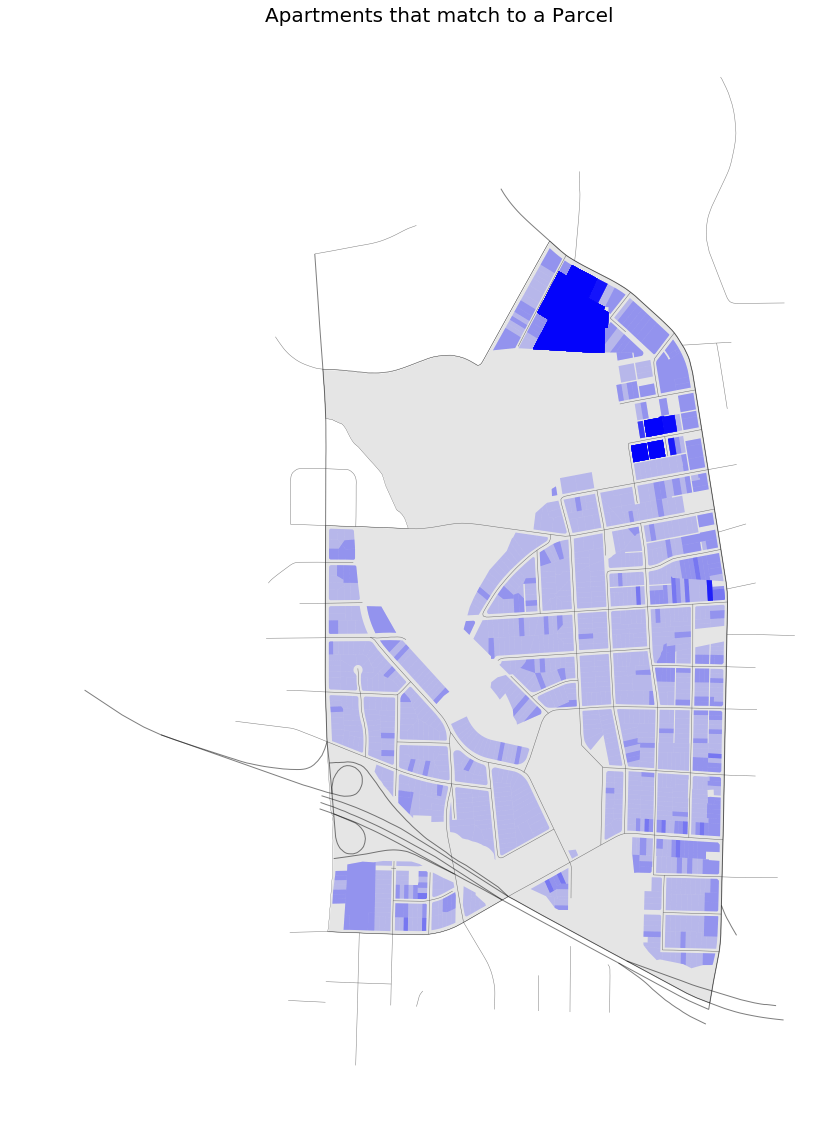

In [11]:
BIG_PLOTSIZE = map(lambda e: e*2, PLOTSIZE)
fig, ax = plt.subplots(1, figsize=BIG_PLOTSIZE)

precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
streets.plot(ax=ax, color='black', edgecolor='black', alpha=0.5, linewidth=0.5)
highways.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
apartments_pd.plot(ax=ax, color='blue', edgecolor='none', alpha=0.2, legend=True)
ax.axis('off')
plt.title('Apartments that match to a Parcel', fontsize=20)

In [25]:
print('Addresses with PARCEL_ID = {}'.format(len(apartments_pd)))

Addresses with PARCEL_ID = 1659


In [13]:
from shapely.geometry import Point
from geopandas.tools import sjoin

geometry = [Point(xy) for xy in zip(all_addresses_and_apartments.long, all_addresses_and_apartments.lat)]
df = all_addresses_and_apartments.drop(['long', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
all_addresses_and_apartments_pd = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
precinct_addresses_pd = sjoin(all_addresses_and_apartments_pd, precinct_boundary_pd, op='within')

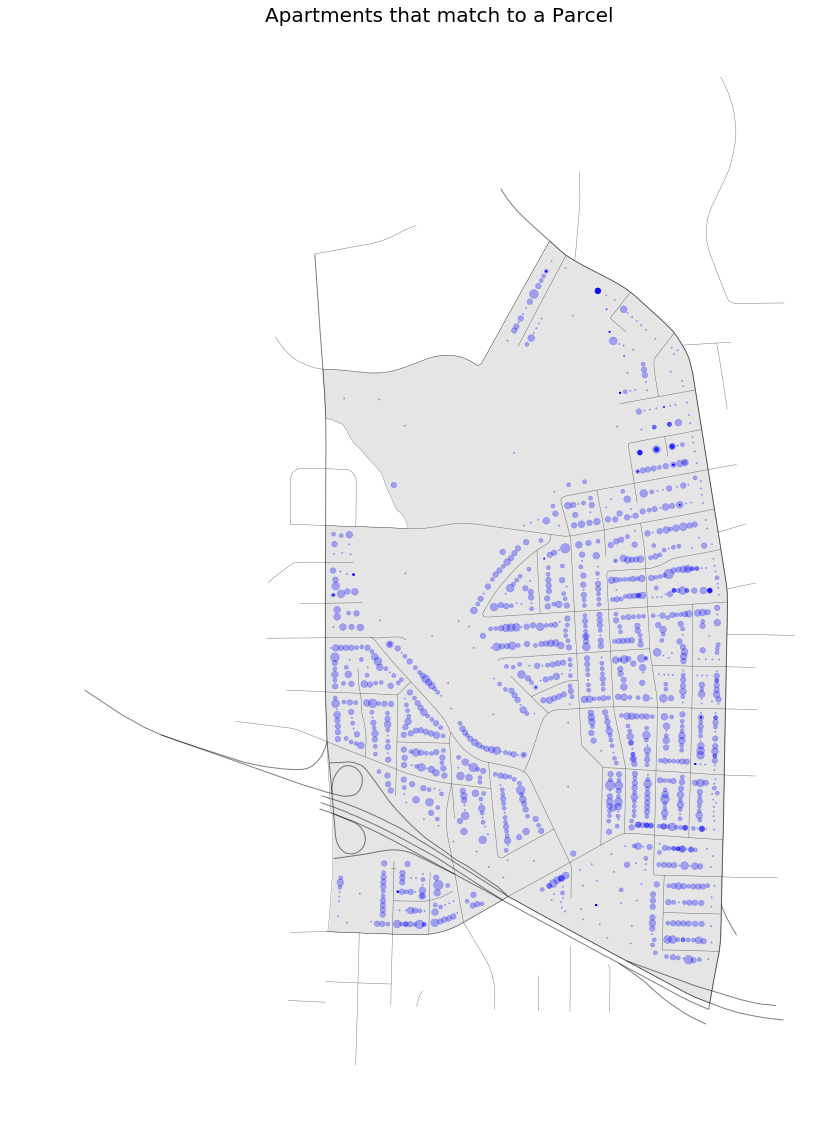

In [16]:
BIG_PLOTSIZE = map(lambda e: e*2, PLOTSIZE)
fig, ax = plt.subplots(1, figsize=BIG_PLOTSIZE)

precinct_boundary_pd.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
streets.plot(ax=ax, color='black', edgecolor='black', alpha=0.5, linewidth=0.5)
highways.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
precinct_addresses_pd.plot(ax=ax, color='blue', marker='o', markersize=(2+15*precinct_addresses_pd.num_voters), alpha=0.3)
ax.axis('off')
plt.title('Apartments that match to a Parcel', fontsize=20)

In [24]:
# precinct_addresses_pd[precinct_addresses_pd]
all_addresses_and_apartments[all_addresses_and_apartments.clean_number_address.str.contains('HAMMOND')]

,PARCEL_ID,clean_number_address,clean_full_street_x,clean_full_street_y,clean_address_x,clean_address_y,lat,long,avg_age,percent_active_voters,num_voters,percent_democrat
index_left,,,,,,,,,,,,
1016,0,102 E HAMMOND ST,NaN,E HAMMOND ST,NaN,102 E HAMMOND ST,0.00000,0.000000,32.000000,1.000000,2,0.500000
1342,0,105 E HAMMOND ST,NaN,E HAMMOND ST,NaN,105 E HAMMOND ST,0.00000,0.000000,78.000000,1.000000,1,1.000000
1387,0,106 E HAMMOND ST,NaN,E HAMMOND ST,NaN,106 E HAMMOND ST,0.00000,0.000000,68.000000,1.000000,1,0.000000
1409,0,107 E HAMMOND ST,NaN,E HAMMOND ST,NaN,107 E HAMMOND ST,0.00000,0.000000,33.000000,1.000000,1,1.000000
1437,0,108 E HAMMOND ST,NaN,E HAMMOND ST,NaN,108 E HAMMOND ST,0.00000,0.000000,58.000000,1.000000,2,0.500000
1464,0,109 E HAMMOND ST,NaN,E HAMMOND ST,NaN,109 E HAMMOND ST,0.00000,0.000000,59.000000,1.000000,2,1.000000
2094,0,114 E HAMMOND ST,NaN,E HAMMOND ST,NaN,114 E HAMMOND ST,0.00000,0.000000,86.000000,1.000000,1,0.000000
7181,0,203 E HAMMOND ST,NaN,E HAMMOND ST,NaN,203 E HAMMOND ST,0.00000,0.000000,48.000000,1.000000,1,1.000000
7282,0,204 E HAMMOND ST,NaN,E HAMMOND ST,NaN,204 E HAMMOND ST,0.00000,0.000000,55.000000,1.000000,1,1.000000
